# Building a Machine Learning Model 

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
dc_data_df = pd.read_csv('dc_data_to_model.csv')
dc_data_df.drop('Unnamed: 0', axis=1, inplace=True)
dc_data_df.head()
#dc_data_df.info()

,OBJECTID,TRACT,GEO,GEOID2,GEO_display_label,Population,Income,Home_value,No_car_percent,Bachelor_or_higher,Employment_percent,Marital_percent,Veterans_percent,Crime_count
0,11,100,1400000US11001000100,11001000100,"Census Tract 1, District of Columbia, District...",5170,168477.0,1048200.0,0.181,0.9129,0.754,0.489,0.082,1.0
1,12,201,1400000US11001000201,11001000201,"Census Tract 2.01, District of Columbia, Distr...",3682,NaN,NaN,NaN,1.0000,0.393,0.010,NaN,NaN
2,13,202,1400000US11001000202,11001000202,"Census Tract 2.02, District of Columbia, Distr...",4473,162981.0,1195300.0,0.168,0.9264,0.641,0.305,0.035,4.0
3,14,300,1400000US11001000300,11001000300,"Census Tract 3, District of Columbia, District...",6374,133008.0,893000.0,0.160,0.8909,0.794,0.313,0.021,2.0
4,15,400,1400000US11001000400,11001000400,"Census Tract 4, District of Columbia, District...",1489,143229.0,1223700.0,0.120,0.7906,0.617,0.497,0.044,NaN


### Preparing the target and features for machine learning

In [3]:
dc_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 14 columns):
OBJECTID              179 non-null int64
TRACT                 179 non-null int64
GEO                   179 non-null object
GEOID2                179 non-null int64
GEO_display_label     179 non-null object
Population            179 non-null int64
Income                177 non-null float64
Home_value            172 non-null float64
No_car_percent        175 non-null float64
Bachelor_or_higher    178 non-null float64
Employment_percent    178 non-null float64
Marital_percent       178 non-null float64
Veterans_percent      177 non-null float64
Crime_count           165 non-null float64
dtypes: float64(8), int64(4), object(2)
memory usage: 19.7+ KB


In [6]:
dc_data_df.isna().sum()

OBJECTID               0
TRACT                  0
GEO                    0
GEOID2                 0
GEO_display_label      0
Population             0
Income                 2
Home_value             7
No_car_percent         4
Bachelor_or_higher     1
Employment_percent     1
Marital_percent        1
Veterans_percent       2
Crime_count           14
dtype: int64

Not much NaN. Will replace them with 0

In [9]:
dc_data_df = dc_data_df.fillna(0)
#dc_data_df.isna().sum()

OBJECTID              0
TRACT                 0
GEO                   0
GEOID2                0
GEO_display_label     0
Population            0
Income                0
Home_value            0
No_car_percent        0
Bachelor_or_higher    0
Employment_percent    0
Marital_percent       0
Veterans_percent      0
Crime_count           0
dtype: int64

In [10]:
dc_data_df['Crime_count'].describe()

count    179.000000
mean       8.720670
std        8.705556
min        0.000000
25%        2.500000
50%        6.000000
75%       12.000000
max       49.000000
Name: Crime_count, dtype: float64

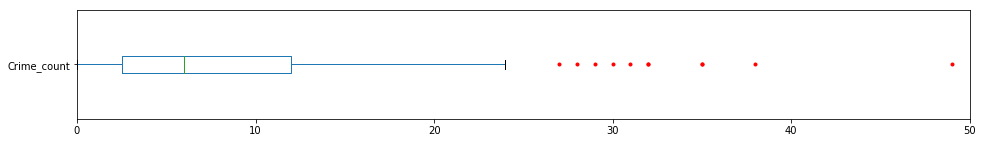

In [13]:
red_box = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
dc_data_df['Crime_count'].plot(kind='box', xlim=(0, 50), vert=False, flierprops=red_box, figsize=(16,2));

The target is crime. However, instead of just the count, it would be better to create a new column that will split the crime_count into high or not. Based on the graph above, 75% of violent crimes have a count of up to 12. If crime count is 12 or greater, I will consider it as a high crime count. Otherwise, the area would be considered not a high violent crime area.

In [14]:
dc_data_df['High_crime'] = dc_data_df['Crime_count'].apply(lambda x: 1 if x >= 12 else 0)
dc_data_df.tail()

Only two columns are objects and neither are relevant for my model, so I will just ignore them as appose to changing them to a category or one-hot-encoding.

In [19]:
dc_data_df = dc_data_df.reset_index() # had to reset the index for my models to work

# features or X
features = dc_data_df[['Population', 'Income', 'Home_value', 'No_car_percent', 'Bachelor_or_higher', 'Employment_percent', 
                       'Marital_percent', 'Veterans_percent']]

# target or y
target = dc_data_df[['High_crime']]

### Machine Learning

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore')

In [20]:
# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [21]:
# scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Support Vector Machine: 79%

In [36]:
# Create the pipeline for SVM
pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('svm', svm.SVC(random_state=123))]);

# Create the grid parameter
grid_svm = [{'svm__kernel': ['poly', 'sigmoid'],
         'svm__C': [0.01, 1, 100],
         'svm__degree': [2,3,4,5],
         'svm__gamma': [0.001, 0.01]}];

# Create the grid, with "pipe" as the estimator
gridsearch_svm = GridSearchCV(estimator=pipe_svm,
                  param_grid=grid_svm,
                  scoring='accuracy',
                  cv=3);

# Fit using grid search
gridsearch_svm.fit(X_train, y_train);
best_parameters = gridsearch_svm.best_params_
best_score = gridsearch_svm.best_score_
print(best_parameters)
print(best_score)

{'svm__C': 100, 'svm__degree': 2, 'svm__gamma': 0.001, 'svm__kernel': 'sigmoid'}
0.7972027972027972


### Random Forest: 83%

In [37]:
# Create the pipeline for Random Forest
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=123))]);

# Create the grid parameter
grid_rf = [{'clf__n_estimators': [100, 120],
            'clf__criterion': ['entropy', 'gini'], 
            'clf__max_depth': [5, 8, 10],
            'clf__min_samples_leaf':[0.05, 0.1, 0.2],
            'clf__min_samples_split':[2, 3, 10]}];

# Create the grid, with "pipe" as the estimator
gridsearch_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid=grid_rf,
                  scoring='accuracy',
                  cv=3);

# Fit using grid search
gridsearch_rf.fit(X_train, y_train);
best_parameters = gridsearch_rf.best_params_
best_score = gridsearch_rf.best_score_
print(best_parameters)
print(best_score)

{'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
0.8391608391608392


### Decison Tree: 78%

In [39]:
# Create the pipeline for Decison Tree
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', tree.DecisionTreeClassifier(random_state=123))])

# Create the grid parameter
grid_dt = [{'clf__criterion': ['entropy', 'gini'], 
            'clf__max_depth': [5, 7, 10],
            'clf__min_samples_leaf':[0.05 ,0.1, 0.2],
            'clf__min_samples_split':[2, 5, 10]}]

# Create the grid, with "pipe" as the estimator
gridsearch_dt = GridSearchCV(estimator=pipe_dt,
                  param_grid=grid_dt,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch_dt.fit(X_train, y_train);
best_parameters = gridsearch_dt.best_params_
best_score = gridsearch_dt.best_score_
print(best_parameters)
print(best_score)

{'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 0.1, 'clf__min_samples_split': 2}
0.7832167832167832


### K-nearest neighboor: 86%

In [41]:
# Create the pipeline for kNN
pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('clf', KNeighborsClassifier())])

# Create the grid parameter
grid_knn = [{'clf__n_neighbors': [3, 5, 7], 
            'clf__p': [1, 2],
            'clf__weights':['uniform', 'distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn = GridSearchCV(estimator=pipe_knn,
                  param_grid=grid_knn,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch_knn.fit(X_train, y_train);
best_parameters = gridsearch_knn.best_params_
best_score = gridsearch_knn.best_score_
print(best_parameters)
print(best_score)

{'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'}
0.8671328671328671


### Logistic Regression: 79%

In [42]:
# Create the pipeline for LR
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression())])

# Create the grid parameter
grid_lr = [{'clf__C': [0.8, 0.9, 1.0, 1.1], 
            'clf__penalty': ['l1', 'l2'],
            'clf__random_state':[1, 5, 10]}]

# Create the grid, with "pipe" as the estimator
gridsearch_lr = GridSearchCV(estimator=pipe_lr,
                  param_grid=grid_lr,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch_lr.fit(X_train, y_train);
best_parameters = gridsearch_lr.best_params_
best_score = gridsearch_lr.best_score_
print(best_parameters)
print(best_score)

{'clf__C': 0.8, 'clf__penalty': 'l2', 'clf__random_state': 1}
0.7972027972027972


From the models tested, Knn had the highest accuracy: 86%. Let's graph a confusion matrix to verify.

## Feature importance

[0.07501501 0.15411043 0.10908106 0.1013205  0.18217735 0.13664001
 0.16210806 0.07954758]


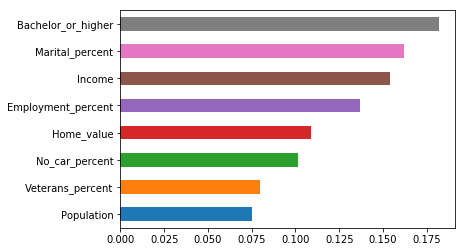

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(features, target)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.show()

From the graph, we see that the three most important features are education, marital status, and income.